# Basel MRI Dataset

Akinci D’Antonoli, T., Todea, R. A., Leu, N., Datta, A. N., Stieltjes, B., Pruefer, F., & Wasserthal, J. (2023). Development and evaluation of deep learning models for automated estimation of myelin maturation using pediatric brain MRI scans. Radiology: Artificial Intelligence, 5(5), e220292.

https://pubs.rsna.org/doi/10.1148/ryai.220292

https://zenodo.org/records/8055666

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import seaborn as sns
import os

from nibabel.processing import resample_to_output

In [2]:
# Load the dataset
# file_path = r'..\..\Datasets\Basel_mri\meta.csv'
file_path = os.path.join("..", "..", "Datasets", "Basel_mri", "meta.csv")
df = pd.read_csv(file_path, sep=';')
df.head()

,image_id,myelinisation,age,age_corrected,doctor_predicted_age,diagnosis,group
0,s0001,normal,22,22,22,normal,train
1,s0002,normal,29,29,29,normal,train
2,s0003,normal,4,4,4,normal,train
3,s0004,normal,0,0,0,normal,train
4,s0005,normal,0,0,0,normal,train


In [3]:
df.describe(include='all')

,image_id,myelinisation,age,age_corrected,doctor_predicted_age,diagnosis,group
count,833,833,833.000000,833.000000,833.000000,833,833
unique,833,2,NaN,NaN,NaN,73,2
top,s0001,normal,NaN,NaN,NaN,normal,train
freq,1,829,NaN,NaN,NaN,565,710
mean,NaN,NaN,13.722689,13.668667,13.669868,NaN,NaN
std,NaN,NaN,11.754957,11.795154,11.795748,NaN,NaN
min,NaN,NaN,0.000000,-1.000000,-1.000000,NaN,NaN
25%,NaN,NaN,3.000000,3.000000,2.000000,NaN,NaN
50%,NaN,NaN,12.000000,12.000000,12.000000,NaN,NaN
75%,NaN,NaN,24.000000,24.000000,24.000000,NaN,NaN


/var/folders/5t/9y469y05463dj441xyl0t6_80000gp/T/ipykernel_25227/4126483834.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='diagnosis_group', y='age', data=df, palette='Set2')


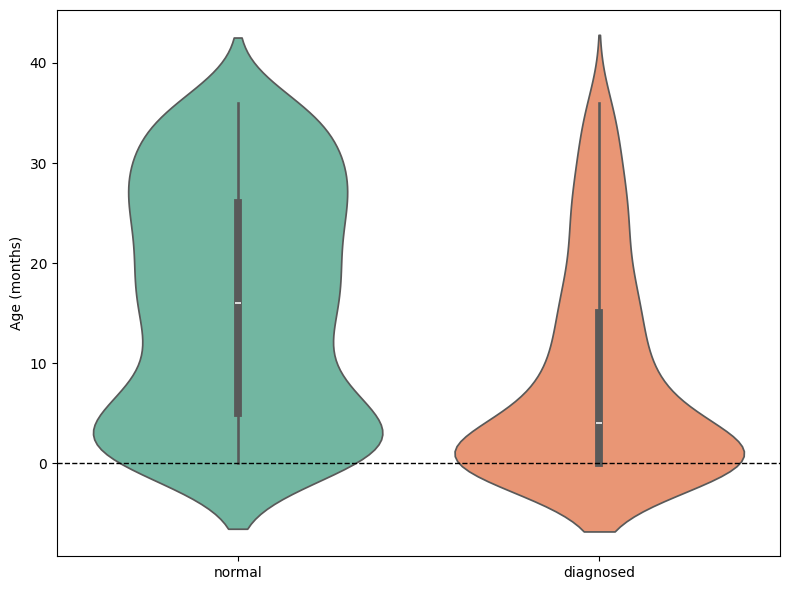

In [4]:
# Create a new column for group labels
df['diagnosis_group'] = df['diagnosis'].apply(lambda x: 'normal' if x.lower() == 'normal' else 'diagnosed')

# Make the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='diagnosis_group', y='age', data=df, palette='Set2')
plt.axhline(y=0, color='k', linestyle='--', lw=1)

plt.xlabel('')
plt.ylabel('Age (months)')
plt.tight_layout()
plt.show()


In [5]:
df['diagnosis'].unique()

array(['normal', 'premature', 'postoperative', 'Leigh Syndrome',
       'brain oedem', 'heterotopia', 'polymicroglia', 'HIE',
       'Hydrocephalus', 'HIE ', 'Premature, PVL', 'encephalocele',
       'Meningitis', 'Premature, PVL, hydrocephalus', 'subdural hygrom',
       'premature, HIE', 'Infarct', 'cerebellar calcification',
       'searing injuries', 'Corpus callosum agenesis',
       'Mithocondriopathy', 'macrocephaly', 'Gliotic foci',
       'premature, hydrocephalus',
       'Delayed myelinisation, cerebral atrophy', 'PVL',
       'Congenital CMV infection', 'cerebral atrophy', 'Arachnoidal cyst',
       'Intracerebral hemorrhage', 'cerebral/cerebellar atrophy',
       'subdurale hemorrhagy', 'Plagiocephaly', 'craniosynostosis',
       'encephalomalasy', 'Macrocephaly', 'Brachycephaly',
       'Septooptic dysplasy', 'Motion artefact',
       'subararachnoidal hemorrhage', 'Premature, Infarct', 'Meningocele',
       'premature, infarct', 'Arnold Chiari Malformation',
       'prem

In [6]:
df_grouped = (
    df.groupby('diagnosis')
      .agg(counts=('diagnosis', 'size'),
           mean_age=('age', 'mean'),
           std_age=('age', 'std'),
           median_age=('age', 'median'),
           min_age=('age', 'min'),
           max_age=('age', 'max'))
      .reset_index()
      .sort_values(by='counts', ascending=False)
)

df_grouped.head(10)


,diagnosis,counts,mean_age,std_age,median_age,min_age,max_age
59,normal,565,16.090265,11.625540,16.0,0,36
13,HIE,45,0.422222,1.514909,0.0,0,8
16,Hydrocephalus,30,13.500000,9.779465,11.5,0,35
17,Infarct,21,2.238095,5.195236,0.0,0,17
21,Meningitis,17,8.294118,6.351818,6.0,0,21
62,premature,9,7.111111,9.184830,2.0,0,26
43,cerebral atrophy,8,12.625000,6.139742,11.5,5,22
72,subdurale hemorrhagy,8,4.500000,5.424811,3.0,0,15
12,Gliotic foci,7,22.142857,11.610750,25.0,0,33
18,Intracerebral hemorrhage,7,8.142857,13.545338,0.0,0,35


In [7]:
df_sel = df[df['diagnosis'] == 'Infarct']
sample_image = df_sel['image_id'].iloc[0]
sample_image

's0088'

In [20]:
def plot_mri_images(t1_img, t2_img):
    
    # Helper to get middle slices
    def get_middle_slices(img):
        x_middle = img[img.shape[0] // 2, :, :]
        y_middle = img[:, img.shape[1] // 2, :]
        z_middle = img[:, :, img.shape[2] // 2]
        return x_middle, y_middle, z_middle
    
    t1_slices = get_middle_slices(t1_img)
    t2_slices = get_middle_slices(t2_img)
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    titles = ['Sagittal (X)', 'Coronal (Y)', ' Axial (Z)']
    
    # T1-weighted images
    for idx, slice_img in enumerate(t1_slices):
        axes[0, idx].imshow(np.rot90(slice_img), cmap='gray')
        axes[0, idx].set_title(f'T1 {titles[idx]}')
        axes[0, idx].axis('off')
    
    # T2-weighted images
    for idx, slice_img in enumerate(t2_slices):
        axes[1, idx].imshow(np.rot90(slice_img), cmap='gray')
        axes[1, idx].set_title(f'T2 {titles[idx]}')
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

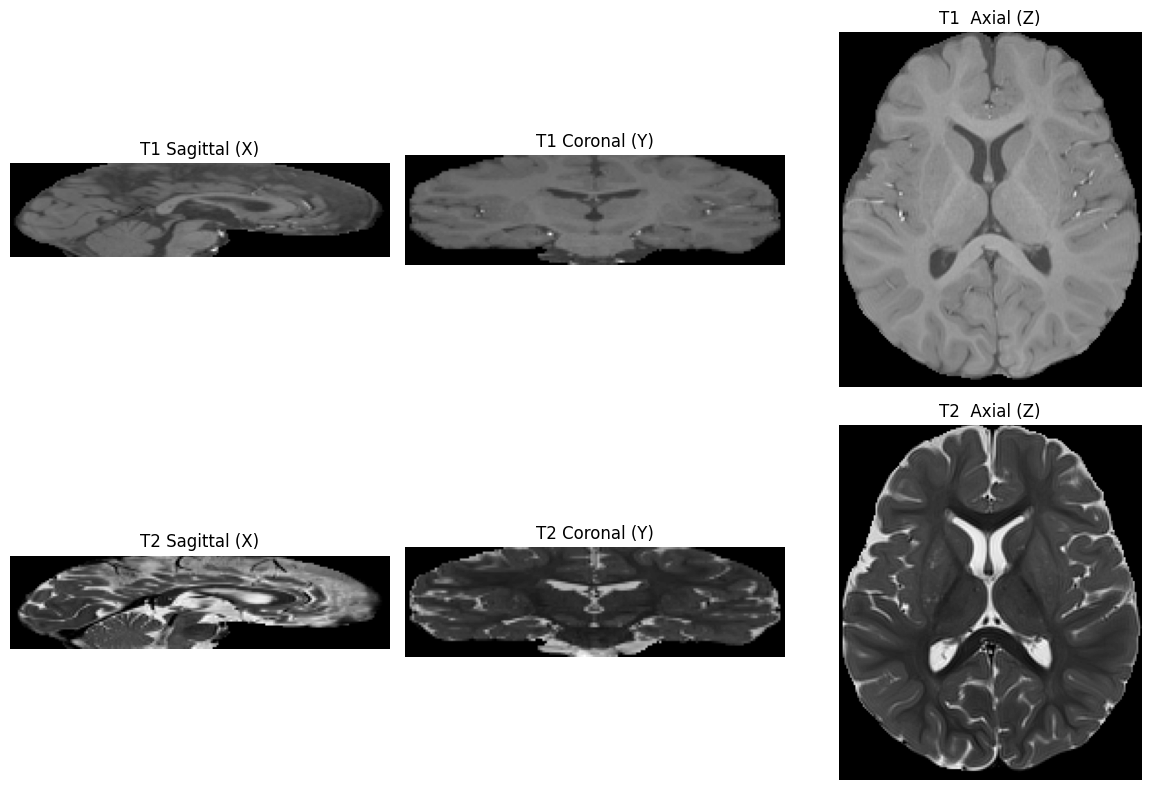

In [21]:
# t1_scan = r'..\..\Datasets\Basel_mri\{}\t1.nii.gz'.format(sample_image)
# t2_scan = r'..\..\Datasets\Basel_mri\{}\t2.nii.gz'.format(sample_image)
t1_scan = os.path.join("..", "..", "Datasets", "Basel_mri", sample_image, "t1.nii.gz")
t2_scan = os.path.join("..", "..", "Datasets", "Basel_mri", sample_image, "t2.nii.gz")

t1_img = nib.load(t1_scan).get_fdata()
t2_img = nib.load(t2_scan).get_fdata()
plot_mri_images(t1_img, t2_img)

In [10]:
t1_img = nib.load(t1_scan)
print(t1_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 166 195  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.          0.78125     0.78124994  2.2         1.          1.
  1.          1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.015712505
quatern_c       : 0.9937047
quatern_d       : 0.11069852
qoffset_x       : 61.954792
qoffset

## Further analysis

each voxel is: 0.491 mm × 0.491 mm × 3.3 mm.  
Which means the Z-dimension is stretched compared to X and Y. (Impacting the coronal and sagittal views).  
[working with affine](https://nipy.org/nibabel/nifti_images.html#the-nifti-affines)

In [11]:
array_data = t1_img.get_fdata()
affine = t1_img.affine  # 4x4 transformation matrix
print(affine)

[[-7.80786097e-01  2.31731907e-02 -3.85695770e-02  6.19547920e+01]
 [ 2.56192759e-02  7.61717081e-01 -4.83518332e-01 -1.03849602e+02]
 [-8.26111250e-03  1.72051176e-01  2.14586186e+00 -4.85767784e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Get the real world size in mm

In [12]:
voxel_sizes = np.abs(np.diag(t1_img.affine))[:3]  # spacing along each axis
physical_size_mm = voxel_sizes * array_data.shape

print("Voxel size (mm):", voxel_sizes) # == pixdim in the header
print("Physical size (mm):", physical_size_mm)


Voxel size (mm): [0.7807861  0.76171708 2.14586186]
Physical size (mm): [129.61049211 148.53483081 103.00136948]


Correcting visualization : 

In [13]:
resampled_t1 = resample_to_output(t1_img, voxel_sizes=(1, 1, 1))  # or any isotropic spacing
print("Resampled shape:", resampled_t1.get_fdata().shape)


Resampled shape: (137, 176, 137)


T2

In [14]:
t2_img = nib.load(t2_scan)
array_data = t2_img.get_fdata()
affine = t2_img.affine

resampled_t2 = resample_to_output(t2_img, voxel_sizes=(1, 1, 1))  # or any isotropic spacing
print("Resampled shape:", resampled_t2.get_fdata().shape)

Resampled shape: (137, 176, 137)


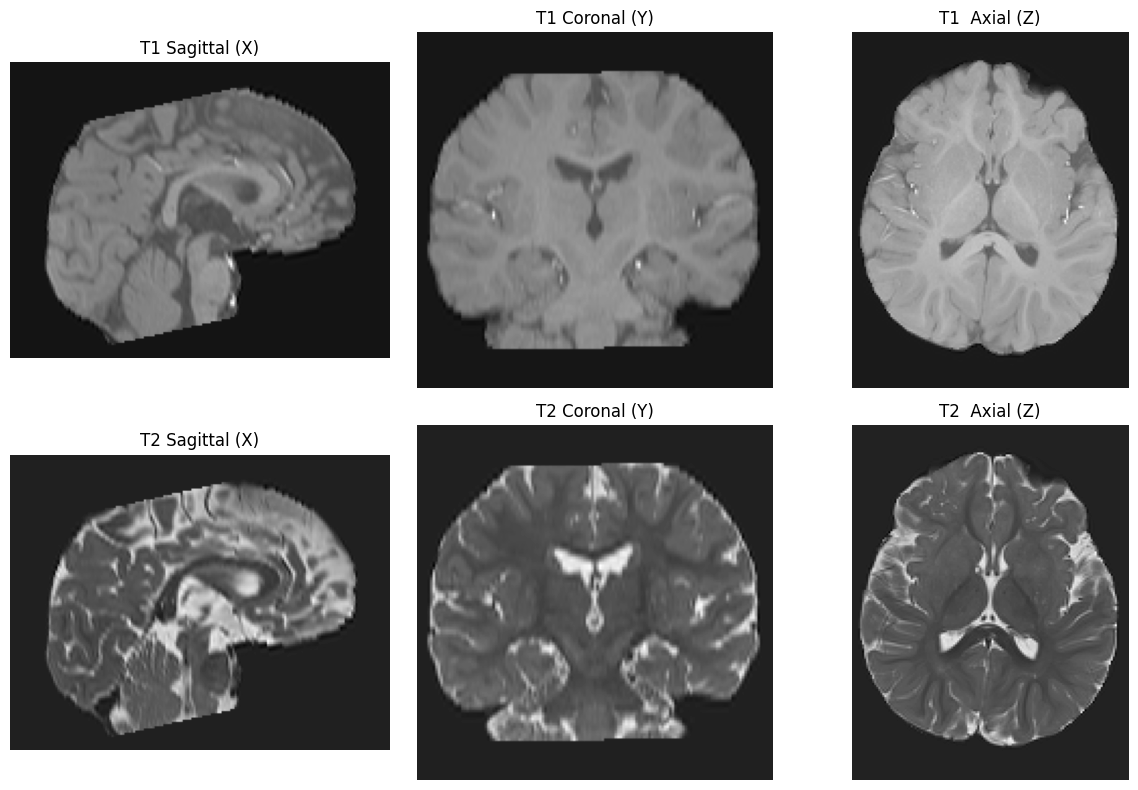

In [22]:
plot_mri_images(resampled_t1.get_fdata(), resampled_t2.get_fdata())

Resampling with lower voxel size -> higher resolution

In [25]:
t1_img = nib.load(t1_scan)
t2_img = nib.load(t2_scan)
resampled_t1_2 = resample_to_output(t1_img, voxel_sizes=(0.5, 0.5, 0.5))  # or any isotropic spacing
resampled_t2_2 = resample_to_output(t2_img, voxel_sizes=(0.5, 0.5, 0.5))  # or any isotropic spacing
print("Resampled shapes:", resampled_t1_2.get_fdata().shape)

Resampled shapes: (272, 351, 273)


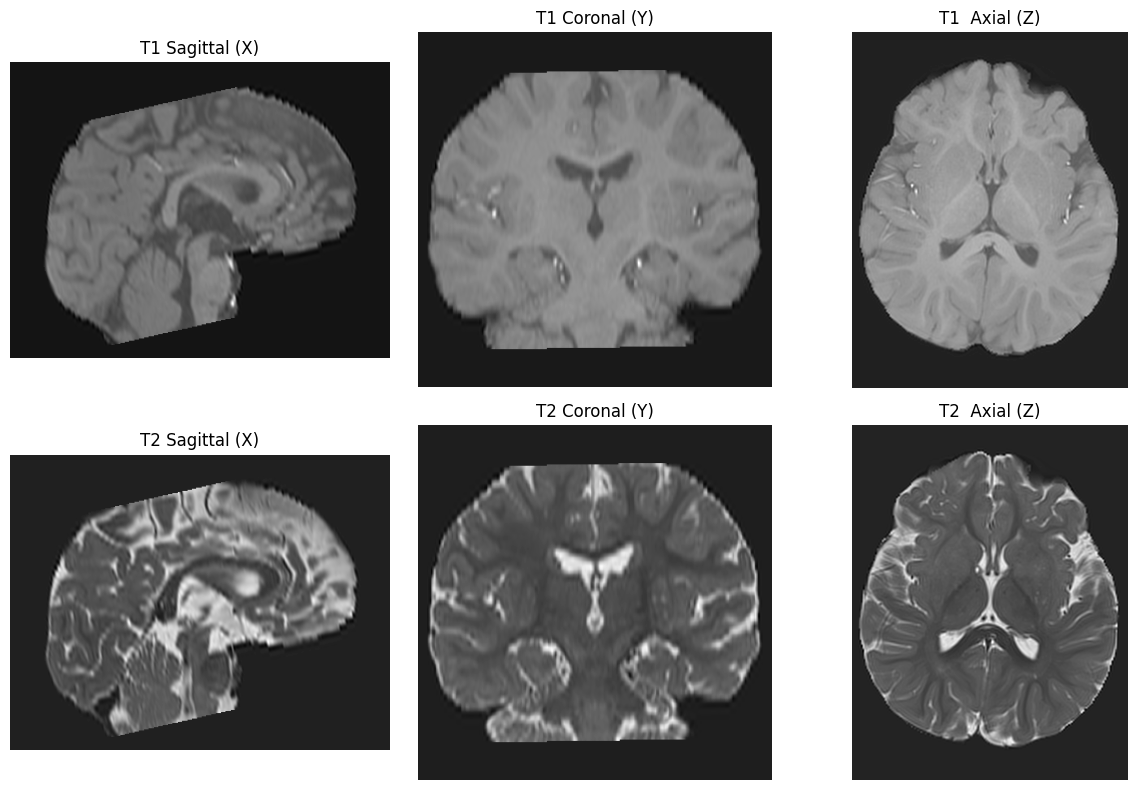

In [26]:
plot_mri_images(resampled_t1_2.get_fdata(), resampled_t2_2.get_fdata())